1. 频率域语音信号-音频折线图
2. 用普减法对音频数据增强

In [14]:
import sys 
sys.path.append("..") 
from Func import ASRfunc

# 读取数据

wave_date, time_table = ASRfunc.read_wave("./data/enhance_speach_input_file.wav")

print(
    "音频数据: {}\n".format(wave_data)+
    "音频长度: {}\n".format(wave_data.shape)+
    "时间长度: {}".format(time_table.shape)
)


音频数据: [ 22  19 -11 ...  55  49  36]
音频长度: (190224,)
时间长度: (190224,)


(1, 190224)


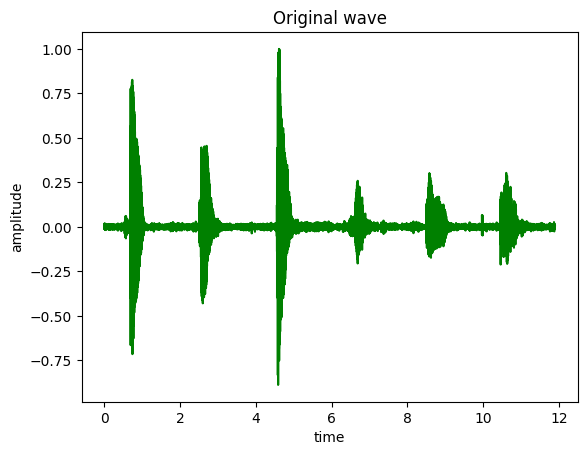

In [11]:
# 音频折线图

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 归一化输入语音
normalized_wave_data = wave_data * 1.0/max(abs(wave_data))
# 将音频信号规整乘每行一路通道信号的格式，即该矩阵一行为一个通道的采样点，共nchannels行
normalized_wave_data = np.reshape(normalized_wave_data,[nframes,nchannels]).T # .T 表示转置
print(normalized_wave_data.shape)

# 绘制输入音频的时域波形
time = np.arange(0,nframes) * (1.0 / framerate)
time = np.reshape(time,[nframes,1]).T

plt.figure()
plt.plot(time_table, normalized_wave_data[0], c="g")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("Original wave")
plt.show()

默认混合信号(含噪信号)的前几帧仅包含环境噪声，并利用混合信号的前几帧的平均幅度谱或者能量谱作为估计到一帧噪声的幅度谱或者能量谱。  
最后利用混合信号(含噪信号)的幅度谱或者能量谱与估计到的幅度谱与能量谱相减，得到估计到的干净信号的幅度谱或者能量谱。

In [4]:
# 谱减法

import wave
import numpy as np
import ctypes as ct
import pandas as pd 
import math

# 自定义函数
class FloatBits(ct.Structure):
    _fields_ = [
        ('M', ct.c_uint, 23),
        ('E', ct.c_uint, 8),
        ('S', ct.c_uint, 1)
    ]

class Float(ct.Union):
    _anonymous_ = ('bits',)
    _fields_ = [
        ('value', ct.c_float),
        ('bits', FloatBits)
    ]

def nextpow2(x):
    if x < 0:
        x = -x
    if x == 0:
        return 0
    d = Float()
    d.value = x
    if d.M == 0:
        return d.E - 127
    return d.E - 127 + 1   

# 计算参数
len_ = 20 * fs // 1000 # 样本中帧的大小
PERC = 50 # 窗口重叠占帧的百分比
len1 = len_ * PERC // 100  # 重叠窗口
len2 = len_ - len1   # 非重叠窗口

# 设置默认参数
Thres = 3 # 信噪比阈值
Expnt = 2.0
beta = 0.002
G = 0.9

# 初始化汉明窗
win = np.hamming(len_)
# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)

# 噪声幅度计算，假设前5帧为silence帧 
nFFT = 2 * 2 ** (nextpow2(len_))
noise_mean = np.zeros(nFFT)

# 分帧处理
j = 0
for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * x[j:j + len_], nFFT))
    j = j + len_
noise_mu = noise_mean / 5
# 分配内存并初始化变量
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)

# 谱减法 
# 根据公式求出每一帧的去噪后的幅值sub_speech
for n in range(0, Nframes):
    # Windowing
    insign = win * x[k-1:k + len_ - 1]
    # FFT变换
    spec = np.fft.fft(insign, nFFT)
    # 计算幅值
    sig = abs(spec)

    # 计算相值
    theta = np.angle(spec)
    # 带噪信号峰值信噪比
    SNRseg = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)


    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR * 3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a


    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR * 2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a

    if Expnt == 1.0:  # 幅度谱
        alpha = berouti1(SNRseg)
    else:  # 功率谱
        alpha = berouti(SNRseg)
    # 纯净信号 = 带噪信号 - 噪声信号
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt;
    # 当纯净信号小于噪声信号的功率时，求差值
    diffw = sub_speech - beta * noise_mu ** Expnt

    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list

    z = find_index(diffw)
    if len(z) > 0:
        # 用估计出来的噪声信号表示下限值
        sub_speech[z] = beta * noise_mu[z] ** Expnt
        
    # 更新噪声的估计
    if SNRseg < Thres: 
        noise_temp = G * noise_mu ** Expnt + (1 - G) * sig ** Expnt  # 平滑处理噪声功率谱
        noise_mu = noise_temp ** (1 / Expnt)  # 新的噪声幅度谱
    # flipud函数实现矩阵的上下翻转，是以矩阵的“水平中线”为对称轴
    # 交换上下对称元素
    sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
    x_phase = (sub_speech ** (1 / Expnt)) * (np.array([math.cos(x) for x in theta]) + img * (np.array([math.sin(x) for x in theta])))
    # take the IFFT

    xi = np.fft.ifft(x_phase).real
    # --- Overlap and add ---------------
    xfinal[k-1:k + len2 - 1] = x_old + xi[0:len1]
    x_old = xi[0 + len1:len_]
    k = k + len2

NameError: name 'fs' is not defined

In [ ]:
import numpy as np
import wave
import math
import ctypes as ct

# 获取语音参数
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate

# 读取波形数据
str_data = f.readframes(nframes)
f.close() # 关闭文件

# 将波形数据转换为数组
x = np.fromstring(str_data, dtype=np.short)

# 归一化输入语音
input_x = x * 1.0/max(abs(x))

# 将音频信号规整乘每行一路通道信号的格式，即该矩阵一行为一个通道的采样点，共nchannels行
input_x = np.reshape(input_x,[nframes,nchannels]).T # .T 表示转置

# 绘制输入音频的时域波形
import matplotlib.pyplot as plt
time = np.arange(0,nframes) * (1.0 / framerate)
time = np.reshape(time,[nframes,1]).T
plt.plot(time[0,:nframes],input_x[0,:nframes],c="b")
plt.xlabel("time(seconds)")
plt.ylabel("amplitude")
plt.title("Original wave")
plt.show()